In [39]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Preparing the Data

In [40]:
dataset = MNIST(root = 'traindata/', download = True, transform = ToTensor())

In [41]:
len(dataset)

60000

In [42]:
image, label = dataset[0]
print(image.shape)

torch.Size([1, 28, 28])


In [43]:
image.permute(1, 2, 0).shape

torch.Size([28, 28, 1])

image.shape torch.Size([1, 28, 28])
label: 5


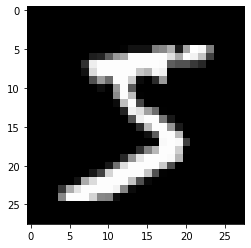

In [44]:
print('image.shape', image.shape)
plt.imshow(image[0], cmap = 'gray')
print('label:', label)

In [45]:
train_ds, val_ds = random_split(dataset, [len(dataset) - 10000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [46]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, 2 * batch_size,num_workers = 4, pin_memory = True)
# If you load your samples in the Dataset on CPU and would like to push it during training 
# to the GPU, you can speed up the host to device transfer by enabling pin_memory = True.

images.shape: torch.Size([128, 1, 28, 28])


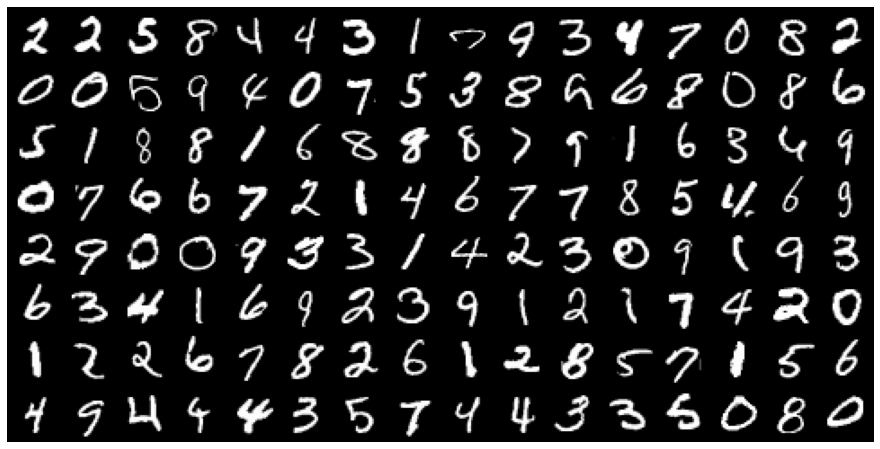

In [47]:
for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize = (16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16).permute((1, 2, 0)))
  break

## Hidden Layers, Activation Functions and Non-Linearity

In [48]:
for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(128, -1)
  print('inputs.shape:', inputs.shape)
  break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [49]:
hidden_size = 32
layer1 = nn.Linear(inputs.shape[1], 32) # 32 nodes in first layer

In [50]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size 784 are transformed into intermediate output vectors of length 32 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias. We can verify this using torch.allclose.


In [51]:
layer1.weight.shape, layer1.bias.shape

(torch.Size([32, 784]), torch.Size([32]))

In [52]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [53]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, layer1_outputs and inputs have a linear relationship, i.e., each element of layer_outputs is a weighted sum of elements from inputs. Thus, even as we train the model and modify the weights, layer1 can only capture linear relationships between inputs and outputs.

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0.

In [54]:
F.relu(torch.tensor([[1, 0, -1], [2, -100, 100]]))

tensor([[  1,   0,   0],
        [  2,   0, 100]])

In [55]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7737144231796265
min(relu_outputs): 0.0


In [56]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [57]:
F.cross_entropy(layer2_outputs, labels).item()

2.296112537384033

Thus, our model transforms inputs into layer2_outputs by applying a linear transformation (using layer1), followed by a non-linear activation (using F.relu), followed by another linear transformation (using layer2). Let's verify this by re-computing the output using basic matrix operations.

In [58]:
layer2.weight.shape

torch.Size([10, 32])

In [59]:
outputs_direct = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias
torch.allclose(outputs_direct, layer2_outputs, 1e-3)

True

Note that outputs and inputs do not have a linear relationship due to the non-linear activation function F.relu. As we train the model and adjust the weights of layer1 and layer2, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since hidden_size does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A deep neural network is simply a neural network with one or more hidden layers. In fact, the Universal Approximation Theorem states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can learn rich and complex non-linear relationships between inputs and targets. Here are some examples:


->Identifying if an image contains a cat or a dog 

->Identifying the genre of a song using a 10-second sample

->Classifying movie reviews as positive or negative based on their content

->Navigating self-driving cars using a video feed of the road

->Translating sentences from English to French (and hundreds of other languages)

->Converting a speech recording to text and vice versa

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [60]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [61]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(784, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [62]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

torch.allclose(outputs2, outputs3, 1e-3) #outputs2 and putputs3 are almost equal, it is uneccessary to use linear activation function

True

## Model

In [63]:
class MnistModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    """Feedfoward neural network with 1 hidden layer"""
    super().__init__()
    self.linear1 = nn.Linear(in_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    outputs1 = F.relu(self.linear1(xb))
    outputs2 =  self.linear2(outputs1)
    return outputs2

  def training_step(self, batch):
    images, labels = batch
    out = self.forward(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self.forward(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [64]:
def accuracy(out, labels):
  _, preds = torch.max(out, dim =1)
  return torch.tensor(torch.sum(preds == labels).item()/ len(preds))

In [65]:
input_size = 784
hidden_size = 32
num_classes = 10 
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [66]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Loss: 2.3085033893585205
outputs.shape: torch.Size([128, 10])
outputs_preds: 0


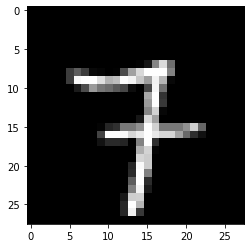

In [67]:
for images, labels in train_loader:
  outputs = model.forward(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('outputs.shape:', outputs.shape)
_, preds = torch.max(outputs, dim = 1)
print('outputs_preds:', preds[0].item())
plt.imshow(images[0].reshape(28, 28), cmap = 'gray')

## Using GPU

In [68]:
torch.cuda.is_available()

True

In [69]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [70]:
device = get_default_device()
device

device(type='cuda')

In [71]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [72]:
for images, labels in train_loader:
  print(images.shape)
  print(images.device)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cpu
cuda:0


In [73]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [74]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [75]:
for xb, yb in val_loader:
  print('xb device:', xb.device)
  print('yd:', yb[0])
  break

xb device: cuda:0
yd: tensor(6, device='cuda:0')


## Training the Model

In [77]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(num_epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []
  for epoch in range(num_epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device.

## Model on GPU

In [78]:
model = MnistModel(input_size, hidden_size, num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [81]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.13144531846046448, 'val_loss': 2.3009562492370605}]

In [82]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2389, val_acc: 0.9317
Epoch [1], val_loss: 0.1652, val_acc: 0.9518
Epoch [2], val_loss: 0.1591, val_acc: 0.9493
Epoch [3], val_loss: 0.1287, val_acc: 0.9607
Epoch [4], val_loss: 0.1328, val_acc: 0.9584


In [84]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1091, val_acc: 0.9681
Epoch [1], val_loss: 0.1070, val_acc: 0.9687
Epoch [2], val_loss: 0.1081, val_acc: 0.9675
Epoch [3], val_loss: 0.1057, val_acc: 0.9677
Epoch [4], val_loss: 0.1058, val_acc: 0.9682


In [85]:
history += fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1052, val_acc: 0.9675
Epoch [1], val_loss: 0.1051, val_acc: 0.9676
Epoch [2], val_loss: 0.1051, val_acc: 0.9674
Epoch [3], val_loss: 0.1050, val_acc: 0.9679
Epoch [4], val_loss: 0.1051, val_acc: 0.9677


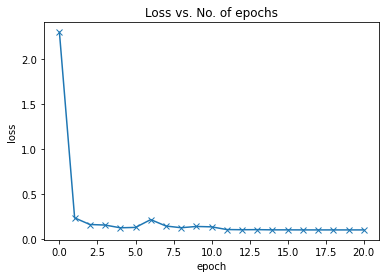

In [88]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

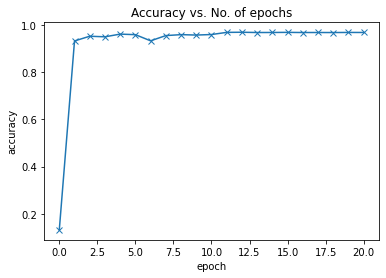

In [89]:
accs = [x['val_acc'] for x in history]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing 

In [91]:
test_dataset = MNIST(root = 'testdata/', train = False, transform = ToTensor(), download=True)

Extracting testdata/MNIST/raw/train-images-idx3-ubyte.gz to testdata/MNIST/raw



Extracting testdata/MNIST/raw/train-labels-idx1-ubyte.gz to testdata/MNIST/raw


Extracting testdata/MNIST/raw/t10k-images-idx3-ubyte.gz to testdata/MNIST/raw


Extracting testdata/MNIST/raw/t10k-labels-idx1-ubyte.gz to testdata/MNIST/raw
Processing...
Done!


In [101]:
# data for testing/training and the model used to training should be on same device.
# For GPU device that is used for trainign the model it needs the data in the GPU memory.
# GPU doesn't have access to our computers RAM which is connected to CPU.
# If multiple GPU data can be moved to different GPU's, so check the device by .device.
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return preds.item()

Label: 7 , Predicted: 7


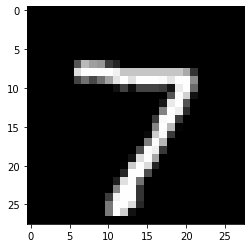

In [102]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


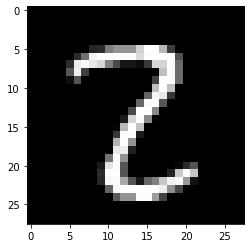

In [103]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


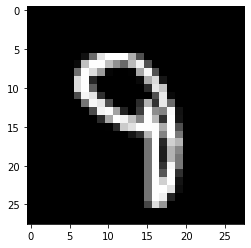

In [104]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [107]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size = 256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.97119140625, 'val_loss': 0.10008030384778976}

In [108]:
torch.save(model.state_dict(), 'mnist_feedforward.pth')